#Signal Quality
This notebook shows how to check the signal quality of EEG for BCI applications. Data has been recorder with the 'Unicorn Hybrid Black' and 'Unicorn Recorder'.

In [88]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.signal as sp
import math

#csv structure
eegColumnStartIndex = 0
eegColumnCount = 8
samplingRate = 250

#load data
data = np.genfromtxt('UnicornRecorder_baseline.csv', delimiter=',')

#remove header
data = np.delete(data, 0, axis=0)

#copy eeg data
eeg = data[:, eegColumnStartIndex:eegColumnCount].copy()
samples = eeg.shape[0]
t = np.linspace(0, samples/samplingRate, num=samples)

##Preprocessing
If you are working with surface EEG most of the signals for common BCI applications (VEP, P300, CVEP, SSVEP, Motor Imagery) are within a frequency range of 0.5-50Hz. If you are acquiring raw EEG you have to deal with a couple of artifacts like power line hum, offsets, drifts etc.

This section shows a simple default pre processing of EEG data for BCI applications. The 50 and 60Hz bandstop filters remove the power line hum, which depends on your geo location (e.g. 50Hz in Europe). The 100 and 120Hz bandstop filters remove multiples of the power line hum. Especially for dry EEG applications these peaks might be visible (when using a low order or no lowpass filter) in the frequency spectrum. The 0.5Hz of the bandpass filter remove offsets and low frequency signals beelow 0.5Hz. The 50Hz part of the bandpass filter removes all the high frequency artifacts.

In [89]:
#define filters
n50Order = 2
n60Order = 2
n100Order = 2
n120Order = 2
hpOrder = 2
lpOrder = 2
n50Fc = 50
n60Fc = 60
hpFc = 0.5
lpFc = 50
b50, a50 = sp.butter(n50Order, [(n50Fc-2)/ (samplingRate / 2), (n50Fc+2)/ (samplingRate / 2)],  btype='bandstop', analog=False)
b60, a60 = sp.butter(n60Order, [(n60Fc-2)/ (samplingRate / 2), (n60Fc+2)/ (samplingRate / 2)], btype='bandstop', analog=False)
b100, a100 = sp.butter(n100Order, [(n50Fc*2-2)/ (samplingRate / 2), (n50Fc*2+2)/ (samplingRate / 2)], btype='bandstop', analog=False)
b120, a120 = sp.butter(n120Order, [(n60Fc*2-2)/ (samplingRate / 2), (n60Fc*2+2)/ (samplingRate / 2)], btype='bandstop', analog=False)
bhp, ahp = sp.butter(hpOrder, hpFc/ (samplingRate / 2), btype='highpass', analog=False)
blp, alp = sp.butter(lpOrder, lpFc/ (samplingRate / 2), btype='lowpass', analog=False)

#filter data
eegfilt = np.zeros_like(eeg)
for i in range(eegColumnCount):
    eegfilt[:,i] = sp.lfilter(b50,a50,eeg[:,i])
    eegfilt[:,i] = sp.lfilter(b60,a60,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(b100,a100,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(b120,a120,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(bhp,ahp,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(blp,alp,eegfilt[:,i])

##Timeseries
In this section EEG is visualized as time series plot. The Amplitude of cleaned EEG used for BCI applications is usually within +- 100µV. The unfiltered signal (blue) includes artifacts like offsets, powerline hum etc. The filtered signal (red) does not contain these artifacts anymore.

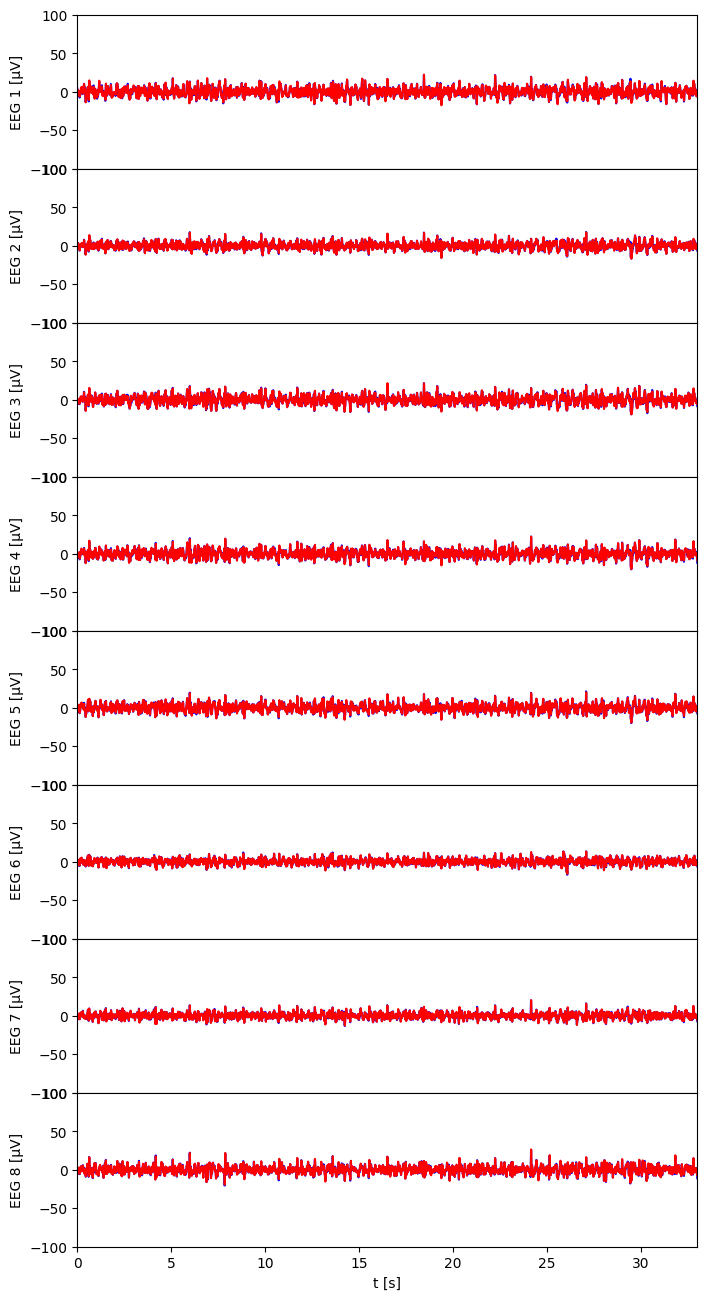

In [90]:
#plot timeseries
fig, axs = mp.subplots(eegColumnCount, 1, sharex=True, figsize=(8, 2*eegColumnCount))
fig.subplots_adjust(hspace=0)
for i in range(eegColumnCount):
    axs[i].plot(t, eeg[:, i], color='blue', linestyle='-')
    axs[i].plot(t, eegfilt[:, i], color='red', linestyle='-')
    axs[i].set_ylabel(f'EEG {i+1} [µV]')
    axs[i].set_ylim(-100, 100)
    axs[i].set_xlim(0, t[t.shape[0]-1])

axs[eegColumnCount - 1].set_xlabel('t [s]')
mp.show()

##Frequency domain
Visualize and plot frequency analysis using pwelch psd analysis. Raw spectrum and filtered spectrum are plotted to visualize the effects of filters on the frequency spectrum. You can see the effect of the notch filters, which remove the power line hum. The 50Hz peak is visible in the raw data (blue) and is removed in the filtered data (red). The EEG should follow a 1/f trend. Low frequency artifacts are removed by the highpass filter (<0.5Hz). High Frequency artifacts are removed by the lowpass filter (>50Hz).

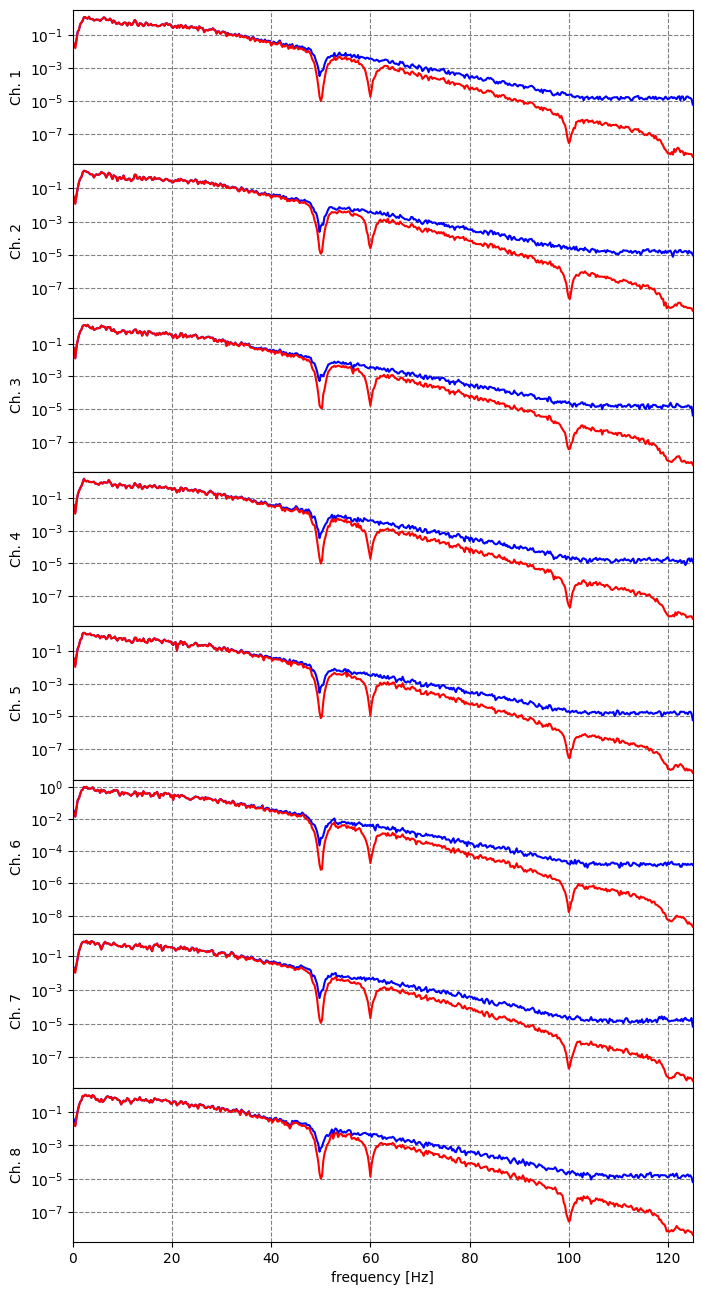

In [91]:
#calculate spectrum
segmentLength = 4 * samplingRate
spectrumRaw = np.zeros((segmentLength // 2 + 1, eegColumnCount))
spectrumFilt = np.zeros((segmentLength // 2 + 1, eegColumnCount))
frequencies = None
for i in range(eegColumnCount):
    frequencies, spectrumRaw[:, i] = sp.welch(eeg[:, i], fs=samplingRate, nperseg=segmentLength, scaling='spectrum', average='median')
    frequencies, spectrumFilt[:, i] = sp.welch(eegfilt[:, i], fs=samplingRate, nperseg=segmentLength, scaling='spectrum', average='median')
spectrumRaw = np.sqrt(spectrumRaw)
spectrumFilt = np.sqrt(spectrumFilt)

#plot spectrum
fig, axs = mp.subplots(eegColumnCount, 1, sharex=True, figsize=(8, 2*eegColumnCount), )
fig.subplots_adjust(hspace=0)
for i in range(eegColumnCount):
    axs[i].semilogy(frequencies, spectrumRaw[:, i], color='blue', linestyle='-')
    axs[i].semilogy(frequencies, spectrumFilt[:, i], color='red', linestyle='-')
    axs[i].grid(True, which="both",ls="--",c='gray')
    axs[i].set_ylabel(f'Ch. {i+1}')
    axs[i].set_xlim(0, frequencies[frequencies.shape[0]-1])

axs[eegColumnCount - 1].set_xlabel('frequency [Hz]')
mp.show()

#Histogram

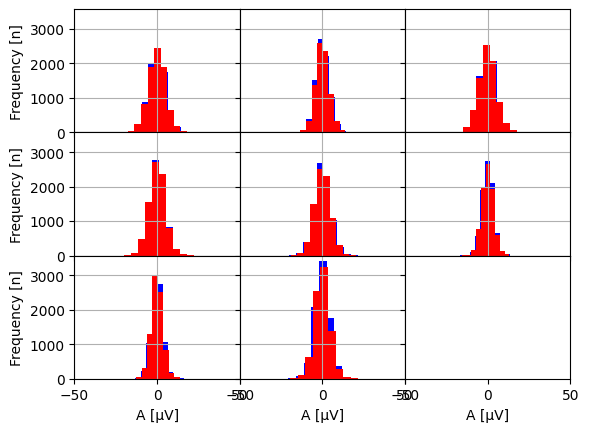

In [92]:
#plot histogram
r = math.ceil(math.sqrt(eegColumnCount))
c = math.ceil(math.sqrt(eegColumnCount))
fig, axs = mp.subplots(r, c, sharex=True, sharey=True )
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(eegColumnCount):
    axs[math.floor(i/c),i%c].grid(True)
    axs[math.floor(i/c),i%c].hist(eeg[:,i], color = "blue")
    axs[math.floor(i/c),i%c].hist(eegfilt[:,i], color = "red")
    axs[math.floor(i/c),i%c].set_xlim(-50, 50)

for i in range(c):
    axs[r-1,i].set_xlabel('A [µV]')

for i in range(r):
    axs[i,0].set_ylabel('Frequency [n]')
mp.show()